# Collector detection model

## Content

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Detect interlayers, that are supposed to be collectors, based on well logs data.

## Dataset

The dataset consists of 12 types of logs (CFTC, CILD, GR, GZ1, GZ2, GZ3, GZ4, GZ7, LLD, NKTD, PROX and SP) and a collector mask, measured for 321 wells. It was split into training and testing subsets with an 80:20 ratio.

In [1]:
import os
import sys
from copy import deepcopy
from functools import partial
sys.path.insert(0, os.path.join("..", "..", "..", ".."))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from petroflow import WellLogsDataset
from petroflow.batchflow import Pipeline, B, V
from petroflow.batchflow.models.tf import UNet
from petroflow.batchflow.models.tf.losses import dice

In [2]:
WELL_NPZ_PATH = "/path/to/npz"
ds = WellLogsDataset(path=WELL_NPZ_PATH, no_ext=True, sort=True)
ds.split(0.8, shuffle=42)

Logs' statistics calculation for further normalization:

In [3]:
def calc_dept_stats(batch):
    dept = np.concatenate(batch.dept)
    return np.nanmin(dept), np.nanmax(dept)

def calc_dept_min_max(dept_stats):
    dept_stats = np.array(dept_stats).T
    return np.nanmin(dept_stats[0]), np.nanmax(dept_stats[1])

def calc_logs_stats(batch):
    logs = np.concatenate(batch.logs, axis=1)
    logs_len = np.nansum(~np.isnan(logs), axis=-1)
    logs_sum = np.nansum(logs, axis=-1)
    logs_sum_of_squares = np.nansum(logs**2, axis=-1)
    return logs_len, logs_sum, logs_sum_of_squares

def calc_logs_mean_std(logs_stats):
    logs_len, logs_sum, logs_sum_of_squares = np.nansum(np.stack(logs_stats), axis=0)
    mean = logs_sum / logs_len
    std = np.sqrt(logs_sum_of_squares / logs_len - mean**2)
    return mean, std

In [4]:
BATCH_SIZE = 32

template_stats_ppl = (Pipeline()
    .init_variable("dept_stats", default=[])
    .init_variable("logs_stats", default=[])
    .load(fmt="npz", components=["dept", "logs"])
    .call(calc_dept_stats, save_to=V("dept_stats"), mode="a")
    .call(calc_logs_stats, save_to=V("logs_stats"), mode="a")
    .run(batch_size=BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=False,
         lazy=True, bar=True)
)

stats_ppl = (ds.train >> template_stats_ppl).run()
dept_min, dept_max = calc_dept_min_max(stats_ppl.get_variable("dept_stats"))
logs_mean, logs_std = calc_logs_mean_std(stats_ppl.get_variable("logs_stats"))

 89%|████████▉ | 8/9 [00:02<00:00,  3.23it/s]


## Model architecture

U-Net model was used to perform required segmentation (https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html). The model was trained on crops of length 128 from the original logs.

Model configuration:
* input shape - [128, 13] (12 logs and depth)
* output shape - [128, 1]
* the number of filters in encoder and corresponding decoder blocks - [16, 32, 64]
* each encoder and decoder block has "cna cna" layout with a kernel size of 3 and a ReLU activation
* downsampling in the encoder is performed by a max pooling operation with a kernel size and a stride of 2
* upsampling in the decoder is performed by a transposed convolution with a kernel size and a stride of 2, followed by batch normalization and a ReLU activation.

Adam optimizer with default parameters was used for model training. Weighted sum of binary crossentropy and dice coefficient was used as a loss function. 

Model configuration specification:

In [5]:
CROP_SIZE = 128

def sigmoid(x):
    return tf.sigmoid(x)[..., 0]

def loss(labels, logits, alpha=1, beta=2, *args, **kwargs):
    bce_loss = alpha * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
    dice_loss = beta * dice(labels, logits, loss_collection=None)
    loss = bce_loss + dice_loss
    tf.losses.add_loss(loss)
    return loss

model_config = {
    "initial_block/inputs": "x",
    "head/num_classes": 1,
    "inputs": dict(x={"shape": (CROP_SIZE, 13)}, 
                   y={"name": "targets", "shape": (CROP_SIZE, 1)}),
    "body/filters": [16, 32, 64],
    "body/encoder": dict(layout="cnacna", kernel_size=3),
    "body/decoder": dict(layout="cnacna", kernel_size=3),
    "body/upsample": dict(layout="tna", kernel_size=2, strides=2),
    "head": dict(layout="c"),
    "loss": loss,
    "optimizer": "Adam",
    "output": sigmoid,
}

## Model training

The model was trained for 250 epochs with a batch size of 32.

In [6]:
N_EPOCH = 250
BATCH_SIZE = 32

Training pipeline specification:

In [7]:
def concatenate_batch(batch, model, concat_mask=True):
    dept = np.concatenate(batch.dept)[..., np.newaxis]
    logs = np.concatenate(batch.logs).swapaxes(1, 2)
    feed_dict = {"x": np.concatenate([dept, logs], axis=-1)}
    if concat_mask:
        feed_dict["y"] = np.concatenate(batch.mask)[..., np.newaxis]
    return {"feed_dict": feed_dict}

In [8]:
template_train_ppl = (Pipeline()
    .init_model("dynamic", UNet, name="unet", config=model_config)
    .init_variable("loss_history", default=[])
    .add_components("mask", B("array_of_nones"))
    .load(fmt="npz", components=["dept", "logs", "mask"])
    .norm_mean_std(mean=logs_mean, std=logs_std, components="logs")
    .norm_min_max(min=dept_min, max=dept_max, components="dept")
    .drop_nans(components_to_split="mask")
    .random_crop(CROP_SIZE, n_crops=4, components=["dept", "logs", "mask"])
    .train_model("unet", make_data=concatenate_batch,
                 fetches="loss", save_to=V("loss_history"), mode="a")
    .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
         lazy=True, bar=True)
)

Model training:

In [9]:
train_ppl = (ds.train >> template_train_ppl)
train_ppl.run()

100%|██████████| 2000/2000 [15:13<00:00,  2.00it/s]


Loss function against the number of epochs:

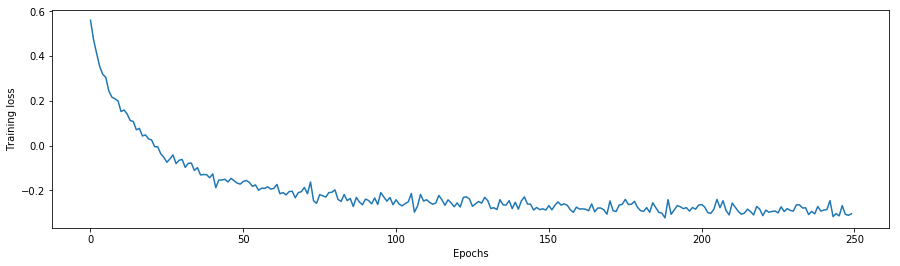

In [10]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss_history"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

Training loss almost reaches a plateau by the end of the training, meaning that the learning process has converged.

## Inference

Inference pipeline:

In [11]:
template_predict_ppl = (Pipeline()
    .import_model("unet", train_ppl)
    .add_components(["mask", "pred"], [B("array_of_nones"), B("array_of_nones")])
    .load(fmt="npz", components=["dept", "logs", "mask"])
    .norm_mean_std(mean=logs_mean, std=logs_std, components="logs")
    .norm_min_max(min=dept_min, max=dept_max, components="dept")
    .drop_nans(components_to_split="mask")
    .crop(CROP_SIZE, step=CROP_SIZE // 8, components=["dept", "logs"])
    .predict_model("unet", make_data=partial(concatenate_batch, concat_mask=False),
                   fetches="sigmoid", save_to=B("pred"), mode="w")
    .split_by_well(components="pred")
    .aggregate(components="pred")
    .run(batch_size=1, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

predict_ppl = (ds.test >> template_predict_ppl)

Prediction visualization:

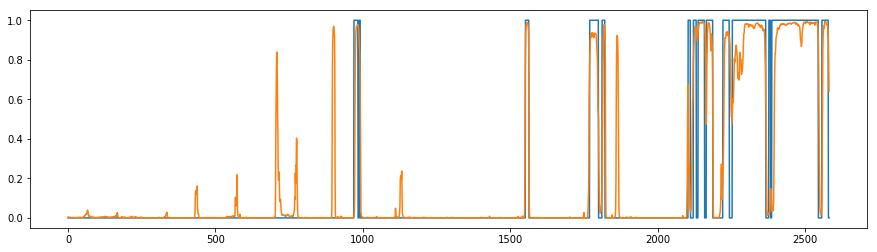

In [12]:
batch = predict_ppl.next_batch()

plt.figure(figsize=(15, 4))
plt.plot(batch.mask[0])
plt.plot(batch.pred[0])
plt.show()

## Model evaluation

Macro and micro averaged F1-scores for a collector class across the wells were used to measure detection performance.

Model evaluation pipeline:

In [13]:
template_test_ppl = (Pipeline()
    .import_model("unet", train_ppl)
    .init_variable("mask", default=[])
    .init_variable("pred", default=[])
    .add_components(["mask", "pred"], [B("array_of_nones"), B("array_of_nones")])
    .load(fmt="npz", components=["dept", "logs", "mask"])
    .norm_mean_std(mean=logs_mean, std=logs_std, components="logs")
    .norm_min_max(min=dept_min, max=dept_max, components="dept")
    .drop_nans(components_to_split="mask")
    .crop(CROP_SIZE, step=CROP_SIZE // 8, components=["dept", "logs"])
    .predict_model("unet", make_data=partial(concatenate_batch, concat_mask=False),
                   fetches="sigmoid", save_to=B("pred"), mode="w")
    .split_by_well(components="pred")
    .aggregate(components="pred")
    .update_variable("mask", B("mask"), mode="a")
    .update_variable("pred", B("pred"), mode="a")
    .run(batch_size=BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

test_ppl = (ds.test >> template_test_ppl)

Metrics evaluation:

In [14]:
test_ppl.run()

Macro-averaged F1-score calculation:

In [15]:
mask = sum((arr.tolist() for arr in test_ppl.get_variable("mask")), [])
pred = sum((arr.tolist() for arr in test_ppl.get_variable("pred")), [])
f1_scores = [f1_score(m, p > 0.5) for m, p in zip(mask, pred)]
f1_score_macro = np.mean(f1_scores)
f1_score_macro

0.6255945419413704

Micro-averaged F1-score calculation:

In [16]:
mask_concat = np.concatenate(mask)
pred_concat = np.concatenate(pred)
f1_score_micro = f1_score(mask_concat, pred_concat > 0.5)
f1_score_micro

0.7209470537178128

Best prediction visualization:

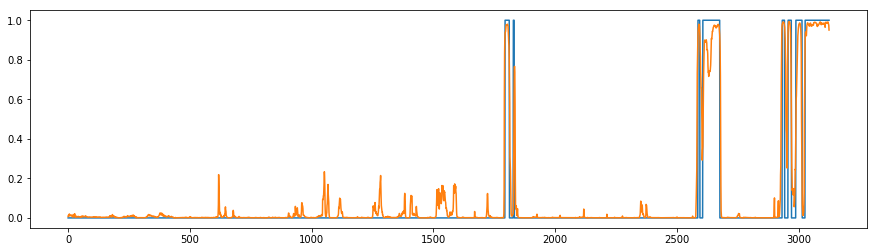

In [17]:
ix = np.argmax(f1_scores)
plt.figure(figsize=(15, 4))
plt.plot(mask[ix])
plt.plot(pred[ix])
plt.show()

## Conclusion

A model for collector detection was trained on 12 types of well logs with a macro-averaged F1-score for a collector class of 0.63.